In [2]:
from __future__ import print_function

import numpy as np
import reflexxes
import random
import math
import copy

# visualiation
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# from hmmlearn import hmm
# from scipy.optimize import linear_sum_assignment
# from sklearn.metrics.pairwise import euclidean_distances

In [83]:
def plot_trajectory(x, title, outliers=[], true_values=None, fixed_axis=True, axis_range=[(0,100),(0,100),(0,100)]):
    x = np.array(x)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    if fixed_axis:
        ax.set_xlim3d(axis_range[0])
        ax.set_ylim3d(axis_range[1])
        ax.set_zlim3d(axis_range[2])
    plt.title(title)
    xline = x[:,0]
    yline = x[:,1]
    zline = x[:,2]
    ax.plot3D(xline, yline, zline, 'green')
    for o in outliers:
        if o != 0 and o != len(x) - 1:
            xline = x[o-1:o+1, 0]
            yline = x[o-1:o+1, 1]
            zline = x[o-1:o+1, 2]
            ax.plot3D(xline, yline, zline, 'red')
    if not true_values is None:
        true_values = np.array(true_values)
        xline = true_values[:,0]
        yline = true_values[:,1]
        zline = true_values[:,2]
        ax.plot3D(xline, yline, zline, 'blue')

In [4]:
def save_to_csv(data, file_name):
    pos_list = []
    for pos in data:
        pos_list.append(pos)
    np.savetxt('data/' + file_name + '.csv', np.array(pos_list))

In [5]:
# used to generate velocity, position and acceleration
def generate_random_variable(lower_limit, higher_limit):
    return [random.randrange(lower_limit, higher_limit), 
            random.randrange(lower_limit, higher_limit), 
            random.randrange(lower_limit, higher_limit)]

In [6]:
def generate_trajectory_recur(gen, count=0, position=None, velocity=None, acceleration=None):
    # set initial values
    gen.current_position = position[-1] if position else generate_random_variable(0, 100)
    gen.current_velocity = velocity[-1] if velocity else generate_random_variable(-10, 10)
    gen.current_acceleration = acceleration[-1] if acceleration else generate_random_variable(0, 5)

    position = position or [gen.current_position.tolist()]
    velocity = velocity or [gen.current_velocity.tolist()]
    acceleration = acceleration or [gen.current_acceleration.tolist()]

    target_position = generate_random_variable(0, 100)
    target_velocity = generate_random_variable(-10, 10)
    
    # generate trajectory
    for pos, vel, acc in gen.trajectory(target_position, target_velocity, 1):
        '''
        auto trajectory(const RMLDoubleVector& target_position,
                    const RMLDoubleVector& target_velocity,
                    double min_sync_time = 0.0)
                    '''
        position.append(pos)
        velocity.append(vel)
        acceleration.append(acc)
        
    if count == 0:
        return position, velocity, acceleration
    else:
        return generate_trajectory_recur(gen, count - 1, position, velocity, acceleration)

In [85]:
def add_noise_to_original_data(original_data, error_range):
    processed_data = []

    # generate random noise with size same as number of points of positions
    noise = np.random.uniform(-error_range, error_range, (original_data.shape[0], original_data.shape[1]))
    # np.random.normal(mean, sigma, (original_data.shape[0], original_data.shape[1]))
    noisy_traj = original_data + noise
    processed_data.extend(noisy_traj)
    
    return processed_data

In [7]:
# arg1: list of positions
# arg2: the rate of outliers to be generated in the list
# return: list of positions with outliers, list of indices of outliers in the position list
def add_outliers(positions, outlier_rate=0.0001):
    positions = copy.deepcopy(positions)
    num = math.floor(len(positions) * outlier_rate)
    choices = random.sample(range(len(positions)), num)
    choices.sort()
    for i in choices:
        positions[i] = generate_random_variable(0, 100)
    return positions, choices

In [8]:
'''
explicit PositionTrajectoryGenerator(unsigned number_of_dofs,
                                    double cycle_time,
                                    const RMLDoubleVector& max_velocity,
                                    const RMLDoubleVector& max_acceleration,
                                    const RMLDoubleVector& max_jerk)
'''
gen = reflexxes.extra.PositionTrajectoryGenerator(
    number_of_dofs=3,
    cycle_time=0.01,
    max_velocity=[10, 10, 10],
    max_acceleration=[8, 8, 8],
    max_jerk=[4, 5, 6]
)

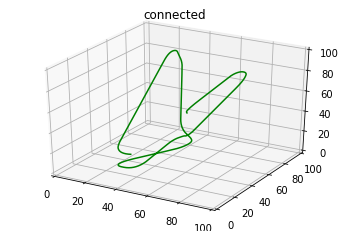

In [44]:
p, v, a = generate_trajectory_recur(gen, 5)

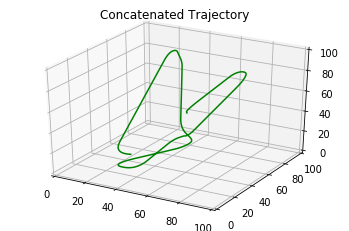

In [57]:
plot_trajectory(p, "Concatenated Trajectory")

In [50]:
# arg1: list of positions
# arg2: the rate of outliers to be generated in the list
# return: list of positions with outliers, list of indices of outliers in the position list
op, c = add_outliers(p, 0.002)

print(len(p))
print(len(c))
print(c[:10])

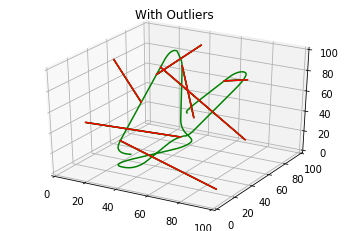

In [56]:
# arg1: real data - to draw out in green
# arg2: title
# arg3 (optional): indices of outliers - to draw out the outliers in red
# arg4 (optional): ground truth - to draw out the true values in blue on top of everything
plot_trajectory(op, "With Outliers", c)

In [41]:
save_to_csv(p, "outlier_0.01-d/ori_position")
save_to_csv(v, "outlier_0.01-d/ori_velocities")
save_to_csv(op, "outlier_0.01-d/with_outlier_position")
save_to_csv(c, "outlier_0.01-d/outlier_indices")

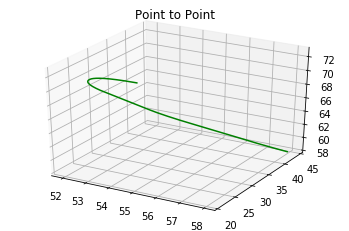

In [68]:
p, v, a = generate_trajectory_recur(gen)
plot_trajectory(p, "Point to Point", fixed_axis=False)

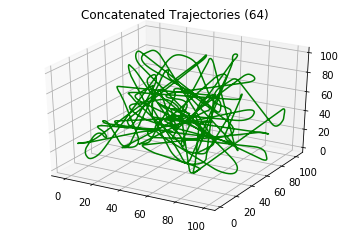

In [105]:
p, v, a = generate_trajectory_recur(gen, 64)
plot_trajectory(p, "Concatenated Trajectories (64)", fixed_axis=False)

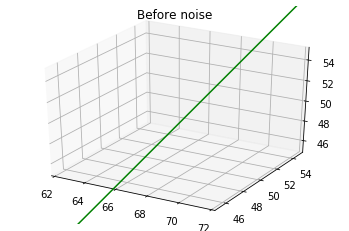

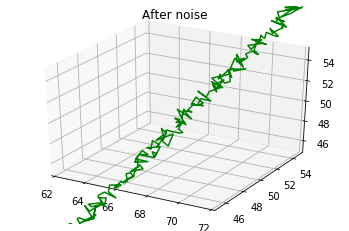

In [88]:
# add noise to positions
noisy_data = add_noise_to_original_data(np.array(p), 0.5)
plot_trajectory(p, 'Before noise', fixed_axis=True, axis_range=[(62,72),(45,55),(45,55)])
plot_trajectory(noisy_data, 'After noise', fixed_axis=True, axis_range=[(62,72),(45,55),(45,55)])